
# EV Fleet Charging Optimization System

This notebook implements an optimization system for EV fleet charging that:
1. Uses genetic algorithms (DEAP) to minimize peak grid load and electricity costs
2. Applies a hybrid optimization step with PuLP to finalize schedules
3. Visualizes results comparing baseline vs optimized load profiles

The system considers time-of-use electricity rates and charging session constraints.


In [9]:
# %%
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import random
from deap import base, creator, tools, algorithms
import pulp
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')


## 1. Data Loading and Preprocessing


In [3]:
class EVChargingData:
    """
    Handles loading and preprocessing of EV charging session data.

    Attributes:
        data (pd.DataFrame): Processed charging session data
        time_of_use_rates (dict): Time-of-use electricity rates by hour
    """

    def __init__(self, filepath=None):
        """
        Initialize with either real data or generate synthetic data if no file provided.

        Args:
            filepath (str): Path to CSV file with charging data. If None, generates synthetic data.
        """
        if filepath:
            self.data = self._load_data(filepath)
        else:
            self.data = self._generate_synthetic_data()

        self._preprocess_data()
        self.time_of_use_rates = self._create_time_of_use_rates()

    def _load_data(self, filepath):
        """Load data from CSV file."""
        return pd.read_csv(filepath)

    def _generate_synthetic_data(self, num_sessions=1000):
        """
        Generate synthetic charging session data when real data isn't available.

        Args:
            num_sessions (int): Number of sessions to generate

        Returns:
            pd.DataFrame: Synthetic charging session data
        """
        np.random.seed(42)

        #data = pd.read_csv("station_data_dataverse.csv")
        # Generate base data
        data = pd.DataFrame({
            'sessionId': range(1, num_sessions + 1),
            'kwhTotal': np.random.uniform(5, 80, num_sessions).round(2),
            'startTime': np.random.randint(1, 24, num_sessions),
            'chargeTimeHrs': np.random.uniform(0.5, 8, num_sessions).round(2),
            'weekday': np.random.choice(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], num_sessions),
            'userId': np.random.randint(1, 200, num_sessions),
            'stationId': np.random.randint(1, 50, num_sessions),
            'managerVehicle': np.random.choice([0, 1], num_sessions, p=[0.8, 0.2]),
            'facilityType': np.random.choice([1, 2, 3, 4], num_sessions, p=[0.3, 0.4, 0.2, 0.1])
        })

        # Generate timestamps
        base_date = datetime(2023, 1, 1)
        data['created'] = data.apply(
            lambda x: (base_date + timedelta(days=np.random.randint(0, 365),
                                             hours=x['startTime'])).strftime('%Y-%m-%d %H:%M:%S'),
            axis=1
        )
        data['ended'] = data.apply(
            lambda x: (datetime.strptime(x['created'], '%Y-%m-%d %H:%M:%S') +
                       timedelta(hours=x['chargeTimeHrs'])), axis=1)

        # Generate end time hour
        data['endTime'] = data.apply(
            lambda x: (datetime.strptime(str(x['ended']), '%Y-%m-%d %H:%M:%S').hour),
            axis=1
        )

        # Generate cost based on kWh and random multiplier
        data['dollars'] = (data['kwhTotal'] * np.random.uniform(0.1, 0.3, num_sessions)).round(2)

        return data

    def _preprocess_data(self):
        """Clean and preprocess the charging session data."""
        # Ensure charge time is positive
        self.data = self.data[self.data['chargeTimeHrs'] > 0]

        # Add binary columns for weekdays if not present
        weekdays = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
        for day in weekdays:
            if day not in self.data.columns:
                self.data[day] = (self.data['weekday'] == day).astype(int)

    def _create_time_of_use_rates(self):
        """
        Create time-of-use electricity rates by hour.

        Returns:
            dict: Hourly electricity rates (keys: 0-23)
        """
        # Peak hours (e.g., 4pm-9pm) have higher rates
        rates = {}
        for hour in range(24):
            if 16 <= hour < 21:  # Peak hours
                rates[hour] = 0.25
            elif 7 <= hour < 16 or 21 <= hour < 23:  # Mid-peak
                rates[hour] = 0.15
            else:  # Off-peak
                rates[hour] = 0.10
        return rates

    def get_charging_sessions(self):
        """Get the processed charging session data."""
        return self.data

    def get_time_of_use_rates(self):
        """Get the time-of-use electricity rates."""
        return self.time_of_use_rates

In [10]:
# Initialize data handler (using synthetic data in this example)
path = "station_data_dataverse.csv"
if not Path(path).exists():
    data_handler_gen = EVChargingData()
else:
    data_handler = EVChargingData(filepath=path)
charging_sessions = data_handler.get_charging_sessions()
time_of_use_rates = data_handler.get_time_of_use_rates()

print(f"Loaded {len(charging_sessions)} charging sessions")
print(charging_sessions.head())

Loaded 3395 charging sessions
   sessionId  kwhTotal  dollars              created                ended  \
0    1366563      7.78     0.00  0014-11-18 15:40:26  0014-11-18 17:11:04   
1    3075723      9.74     0.00  0014-11-19 17:40:26  0014-11-19 19:51:04   
2    4228788      6.76     0.58  0014-11-21 12:05:46  0014-11-21 16:46:04   
3    3173284      6.17     0.00  0014-12-03 19:16:12  0014-12-03 21:02:18   
4    3266500      0.93     0.00  0014-12-11 20:56:11  0014-12-11 21:14:06   

   startTime  endTime  chargeTimeHrs weekday platform  ...  Mon  Tues  Wed  \
0         15       17       1.510556     Tue  android  ...    0     1    0   
1         17       19       2.177222     Wed  android  ...    0     0    1   
2         12       16       4.671667     Fri  android  ...    0     0    0   
3         19       21       1.768333     Wed  android  ...    0     0    1   
4         20       21       0.298611     Thu  android  ...    0     0    0   

   Thurs  Fri  Sat  Sun  reportedZip  


## 2. Genetic Algorithm Optimization (DEAP)

We'll use a genetic algorithm to find charging schedules that minimize:
1. Peak grid load (primary objective)
2. Electricity costs (secondary objective)


In [6]:
class GeneticAlgorithmOptimizer:
    """
    Implements genetic algorithm optimization for EV charging schedules using DEAP.

    Attributes:
        charging_sessions (pd.DataFrame): EV charging session data
        time_of_use_rates (dict): Electricity rates by hour
        power_capacity (float): Total available power capacity (kW)
        time_slots (int): Number of time slots in optimization horizon
        population_size (int): GA population size
        generations (int): Number of GA generations
        cxpb (float): Crossover probability
        mutpb (float): Mutation probability
    """

    def __init__(self, charging_sessions, time_of_use_rates,
                 power_capacity=1000, time_slots=24,
                 population_size=50, generations=100,
                 cxpb=0.7, mutpb=0.3):
        """
        Initialize the genetic algorithm optimizer.

        Args:
            charging_sessions: DataFrame of charging sessions
            time_of_use_rates: Dictionary of electricity rates by hour
            power_capacity: Total available power capacity in kW
            time_slots: Number of time slots to optimize over
            population_size: Size of GA population
            generations: Number of GA generations
            cxpb: Crossover probability
            mutpb: Mutation probability
        """
        self.charging_sessions = charging_sessions
        self.time_of_use_rates = time_of_use_rates
        self.power_capacity = power_capacity
        self.time_slots = time_slots
        self.population_size = population_size
        self.generations = generations
        self.cxpb = cxpb
        self.mutpb = mutpb

        # Average charging power per session (kW)
        self.charging_sessions['avg_power'] = (
                self.charging_sessions['kwhTotal'] / self.charging_sessions['chargeTimeHrs']
        )

        # Setup DEAP framework
        self._setup_deap()

    def _setup_deap(self):
        """Setup the DEAP framework with fitness and individual classes."""
        # Define fitness (minimize both objectives)
        creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0))

        # Define individual (list of start time offsets)
        creator.create("Individual", list, fitness=creator.FitnessMulti)

        # Initialize toolbox
        self.toolbox = base.Toolbox()

        # Attribute generator: random start time offset (0 to max_offset)
        max_offset = self.time_slots - 1
        self.toolbox.register("attr_int", random.randint, 0, max_offset)

        # Structure initializers
        self.toolbox.register("individual", tools.initRepeat,
                              creator.Individual, self.toolbox.attr_int,
                              n=len(self.charging_sessions))
        self.toolbox.register("population", tools.initRepeat, list, self.toolbox.individual)

        # Register evaluation, crossover, mutation and selection functions
        self.toolbox.register("evaluate", self._evaluate)
        self.toolbox.register("mate", tools.cxTwoPoint)
        self.toolbox.register("mutate", tools.mutUniformInt, low=0,
                              up=self.time_slots - 1, indpb=0.1)
        self.toolbox.register("select", tools.selNSGA2)

    def _evaluate(self, individual):
        """
        Evaluate the fitness of an individual (charging schedule).

        Args:
            individual: List of start time offsets

        Returns:
            tuple: (peak_load, total_cost) fitness values
        """
        # Calculate charging profiles for all sessions
        load_profile = np.zeros(self.time_slots)
        total_cost = 0.0

        for i, session in self.charging_sessions.iterrows():
            # Get scheduled start time (original start time + offset)
            original_start = session['startTime']
            scheduled_start = (original_start + individual[i]) % self.time_slots

            # Calculate charging duration in time slots
            duration = min(int(np.ceil(session['chargeTimeHrs'])), self.time_slots)

            # Calculate average power for this session
            avg_power = session['avg_power']

            # Add to load profile
            for t in range(duration):
                time_slot = (scheduled_start + t) % self.time_slots
                load_profile[time_slot] += avg_power

                # Add to cost based on time-of-use rate
                total_cost += avg_power * self.time_of_use_rates[time_slot]

        # Calculate peak load
        peak_load = np.max(load_profile)

        # Penalize if peak exceeds capacity
        if peak_load > self.power_capacity:
            peak_load += 10 * (peak_load - self.power_capacity)

        return (peak_load, total_cost)

    def optimize(self):
        """
        Run the genetic algorithm optimization.

        Returns:
            list: Pareto front of optimal solutions
            log: Statistics log
        """
        # Initialize population
        pop = self.toolbox.population(n=self.population_size)

        # Evaluate the entire population
        fitnesses = list(map(self.toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # Begin the evolution
        stats = tools.Statistics(lambda ind: ind.fitness.values)
        stats.register("avg", np.mean, axis=0)
        stats.register("std", np.std, axis=0)
        stats.register("min", np.min, axis=0)
        stats.register("max", np.max, axis=0)

        logbook = tools.Logbook()
        logbook.header = "gen", "evals", "std", "min", "avg", "max"

        # Record statistics for initial population
        record = stats.compile(pop)
        logbook.record(gen=0, evals=len(pop), **record)

        for gen in range(1, self.generations + 1):
            # Select the next generation individuals
            offspring = self.toolbox.select(pop, len(pop))

            # Clone the selected individuals
            offspring = list(map(self.toolbox.clone, offspring))

            # Apply crossover and mutation
            for child1, child2 in zip(offspring[::2], offspring[1::2]):
                if random.random() < self.cxpb:
                    self.toolbox.mate(child1, child2)
                    del child1.fitness.values
                    del child2.fitness.values

            for mutant in offspring:
                if random.random() < self.mutpb:
                    self.toolbox.mutate(mutant)
                    del mutant.fitness.values

            # Evaluate the individuals with an invalid fitness
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = map(self.toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit

            # Replace population
            pop[:] = offspring

            # Record statistics
            record = stats.compile(pop)
            logbook.record(gen=gen, evals=len(invalid_ind), **record)

        # Get Pareto front solutions
        pareto_front = tools.sortNondominated(pop, len(pop), first_front_only=True)[0]

        return pareto_front, logbook

    def decode_schedule(self, individual):
        """
        Decode an individual into a charging schedule DataFrame.

        Args:
            individual: GA individual representing a schedule

        Returns:
            pd.DataFrame: Charging schedule with session details
        """
        schedule = self.charging_sessions.copy()
        schedule['scheduled_start'] = [
            (schedule.loc[i, 'startTime'] + individual[i]) % self.time_slots
            for i in range(len(schedule))
        ]
        schedule['scheduled_end'] = (
                schedule['scheduled_start'] + np.ceil(schedule['chargeTimeHrs'])
        ).mod(self.time_slots)
        return schedule

In [7]:
# Initialize and run genetic algorithm optimizer
ga_optimizer = GeneticAlgorithmOptimizer(
    charging_sessions=charging_sessions,
    time_of_use_rates=time_of_use_rates,
    power_capacity=500,  # kW
    population_size=30,
    generations=50
)

print("Running GA optimizing")
pareto_front, logbook = ga_optimizer.optimize()

Running GA optimizing



## 3. Hybrid Optimization with PuLP

We'll use linear programming to refine the best solution from the genetic algorithm.


In [18]:
def check_solvers():
    """Check which solvers are properly installed and working."""
    solvers = {
        'CBC': pulp.PULP_CBC_CMD,
        'GLPK': pulp.GLPK_CMD,
        'SCIP': pulp.SCIP_CMD
    }
    
    working_solvers = []
    for name, solver in solvers.items():
        try:
            test_prob = pulp.LpProblem("Test", pulp.LpMinimize)
            x = pulp.LpVariable('x', lowBound=0)
            test_prob += x
            solver().solve(test_prob)
            working_solvers.append(name)
            print(f"{name} solver is working")
        except Exception as e:
            print(f"{name} solver failed: {str(e)}")
    
    if not working_solvers:
        print("No solvers working - will use fallback methods")
    return working_solvers

In [20]:
print(check_solvers())

CBC solver is working
GLPK solver failed: PuLP: cannot execute glpsol.exe
SCIP solver failed: PuLP: cannot execute scip.exe
['CBC']


In [21]:
solver_list = pulp.listSolvers()
print(solver_list)

['CyLP', 'GLPK_CMD', 'PYGLPK', 'CPLEX_CMD', 'CPLEX_PY', 'GUROBI', 'GUROBI_CMD', 'MOSEK', 'XPRESS', 'XPRESS', 'XPRESS_PY', 'PULP_CBC_CMD', 'COIN_CMD', 'COINMP_DLL', 'CHOCO_CMD', 'MIPCL_CMD', 'SCIP_CMD', 'FSCIP_CMD', 'SCIP_PY', 'HiGHS', 'HiGHS_CMD', 'COPT', 'COPT_DLL', 'COPT_CMD', 'SAS94', 'SASCAS']


In [54]:
class LinearProgrammingOptimizer:
    """
    Implements linear programming optimization for final schedule refinement using PuLP.

    Attributes:
        charging_sessions (pd.DataFrame): EV charging session data
        time_of_use_rates (dict): Electricity rates by hour
        power_capacity (float): Total available power capacity (kW)
        time_slots (int): Number of time slots in optimization horizon
    """

    def __init__(self, charging_sessions, time_of_use_rates, power_capacity=1000, time_slots=24):
        """
        Initialize the linear programming optimizer.

        Args:
            charging_sessions: DataFrame of charging sessions
            time_of_use_rates: Dictionary of electricity rates by hour
            power_capacity: Total available power capacity in kW
            time_slots: Number of time slots to optimize over
        """
        self.charging_sessions = charging_sessions
        self.time_of_use_rates = time_of_use_rates
        self.power_capacity = power_capacity
        self.time_slots = time_slots

        # Calculate average power for each session
        self.charging_sessions['avg_power'] = (
                self.charging_sessions['kwhTotal'] / self.charging_sessions['chargeTimeHrs']
        )
        self.prob = None
        self.available_solvers = self._detect_available_solvers()

    def _detect_available_solvers(self):
        """Detect which solvers are availabglle on the system."""
        solvers = []
        
        # Test CBC first (most recommended)
        try:
            pulp.PULP_CBC_CMD().available()
            solvers.append(('CBC', pulp.PULP_CBC_CMD))
        except:
            pass
        
        # Test GLPK
        try:
            pulp.GLPK_CMD().available()
            solvers.append(('GLPK', pulp.GLPK_CMD))
        except:
            pass
        
        # Test SCIP if installed
        try:
            pulp.SCIP_CMD().available()
            solvers.append(('SCIP', pulp.SCIP_CMD))
        except:
            pass
        
        # Fallback to default
        solvers.append(('PULP_DEFAULT', None))
        
        return solvers
        
    def optimize1(self, initial_schedule=None):
        """
        Run the linear programming optimization.

        Args:
            initial_schedule: Initial schedule from GA to use as starting point

        Returns:
            pd.DataFrame: Optimized charging schedule
            dict: Load profile by time slot
        """
        # Create the LP problem
        last_error = None
        
        for solver_name, solver_class in self.available_solvers:
            try:
                print(f"Trying solver: {solver_name}")
                self.prob = pulp.LpProblem("EV_Charging_Optimization", pulp.LpMinimize)
                
                # Create variables
                num_sessions = len(self.charging_sessions)
                start_vars = pulp.LpVariable.dicts(
                    "start", range(num_sessions),
                    lowBound=0, upBound=self.time_slots-1,
                    cat='Integer'
                )
                
                # Objective and constraints
                peak_load = pulp.LpVariable("peak_load", lowBound=0)
                self.prob += 10 * peak_load + pulp.lpSum(
                    self._calculate_session_cost(i, start_vars[i])
                    for i in range(num_sessions)
                )
                
                for t in range(self.time_slots):
                    self.prob += peak_load >= self._calculate_time_slot_load(t, start_vars)
                self.prob += peak_load <= self.power_capacity
                
                # Solve with current solver
                solver = solver_class(msg=False) if solver_class else None
                solve_status = self.prob.solve(solver)
                
                if solve_status != pulp.LpStatusOptimal:
                    raise pulp.PulpSolverError(f"Solver {solver_name} did not find optimal solution")
                
                # Extract solution
                optimized_schedule = self.charging_sessions.copy()
                optimized_schedule['scheduled_start'] = [
                    int(pulp.value(start_vars[i])) for i in range(num_sessions)]
                optimized_schedule['scheduled_end'] = (
                    optimized_schedule['scheduled_start'] + 
                    np.ceil(optimized_schedule['chargeTimeHrs'])
                ).mod(self.time_slots)
                
                load_profile = self._calculate_final_load_profile(optimized_schedule)
                return optimized_schedule, load_profile, solver_name
                
            except Exception as e:
                last_error = e
                print(f"Solver {solver_name} failed: {str(e)}")
                continue
        
        print("All solvers failed. Using genetic algorithm results as fallback.")
        print(f"Last error: {str(last_error)}")
        return None, None, "FAILED"

    def optimize(self, initial_schedule=None):
        """Try optimization with different approaches."""
        # First try with proper solvers
        for solver_name in self.available_solvers:
            try:
                result = self._solve_with_solver(solver_name, initial_schedule)
                if result:
                    return result + (solver_name,)
            except Exception as e:
                print(f"Solver {solver_name} failed: {str(e)}")
                continue
        
        # If all solvers failed, use heuristic approach
        print("Using heuristic fallback method")
        return self._heuristic_optimization(initial_schedule), "HEURISTIC"

    def _solve_with_solver(self, solver_name, initial_schedule):
        """Try solving with a specific solver."""
        solver_map = {
            'CBC': pulp.PULP_CBC_CMD(msg=False),
            'GLPK': pulp.GLPK_CMD(msg=False),
            'SCIP': pulp.SCIP_CMD(msg=False)
        }
        
        prob = pulp.LpProblem("EV_Charging_Optimization", pulp.LpMinimize)
        
        # Create variables and constraints
        num_sessions = len(self.charging_sessions)
        start_vars = pulp.LpVariable.dicts(
            "start", range(num_sessions),
            lowBound=0, upBound=self.time_slots-1,
            cat='Integer'
        )
        
        peak_load = pulp.LpVariable("peak_load", lowBound=0)
        prob += 10 * peak_load + pulp.lpSum(
            self._calculate_session_cost(i, start_vars[i])
            for i in range(num_sessions)
        )
        
        for t in range(self.time_slots):
            prob += peak_load >= self._calculate_time_slot_load(t, start_vars)
        prob += peak_load <= self.power_capacity
        
        # Solve
        solver = solver_map.get(solver_name)
        status = prob.solve(solver)
        
        if status != pulp.LpStatusOptimal:
            raise pulp.PulpSolverError(f"No optimal solution found with {solver_name}")
        
        # Extract solution
        optimized_schedule = self.charging_sessions.copy()
        optimized_schedule['scheduled_start'] = [
            int(pulp.value(start_vars[i])) for i in range(num_sessions)]
        optimized_schedule['scheduled_end'] = (
            optimized_schedule['scheduled_start'] + 
            np.ceil(optimized_schedule['chargeTimeHrs'])
        ).mod(self.time_slots)
        
        load_profile = self._calculate_final_load_profile(optimized_schedule)
        return optimized_schedule, load_profile

    def _heuristic_optimization(self, initial_schedule):
        """Fallback optimization when solvers fail."""
        if initial_schedule is not None:
            # Use GA results if available
            optimized_schedule = initial_schedule.copy()
        else:
            # Simple heuristic: spread out charging based on power needs
            optimized_schedule = self.charging_sessions.copy()
            optimized_schedule = optimized_schedule.sort_values('avg_power', ascending=False)
            optimized_schedule['scheduled_start'] = np.linspace(
                0, self.time_slots-1, len(optimized_schedule), dtype=int
            )
        
        optimized_schedule['scheduled_end'] = (
            optimized_schedule['scheduled_start'] + 
            np.ceil(optimized_schedule['chargeTimeHrs'])
        ).mod(self.time_slots)
        
        load_profile = self._calculate_final_load_profile(optimized_schedule)
        return optimized_schedule, load_profile
        
    def _calculate_session_cost(self, session_idx, start_var):
        """
        Calculate the cost of a charging session based on its start time.

        Args:
            session_idx: Index of the charging session
            start_var: PuLP variable representing start time

        Returns:
            LpAffineExpression: Cost expression for the session
        """
        session = self.charging_sessions.iloc[session_idx]
        duration = int(np.ceil(session['chargeTimeHrs']))
        avg_power = session['avg_power']

        cost_expr = 0
        for t_offset in range(duration):
            # Create binary indicator for each possible start time
            for possible_start in range(self.time_slots):
                # Create a binary variable that is 1 if session starts at possible_start
                # and 0 otherwise (we'll use this to calculate the correct time slot)
                start_indicator = pulp.LpVariable(
                    f"start_ind_{session_idx}_{possible_start}", 
                    cat='Binary'
                )
                
                # The actual time slot is (possible_start + t_offset) % self.time_slots
                time_slot = (possible_start + t_offset) % self.time_slots
                rate = self.time_of_use_rates[time_slot]
                
                # Add to cost if this is the actual start time
                cost_expr += avg_power * rate * start_indicator

        return cost_expr

    def _calculate_time_slot_load(self, time_slot, start_vars):
        """
        Calculate load in a specific time slot based on start variables.

        Args:
            time_slot: Time slot to calculate load for
            start_vars: Dictionary of start time variables

        Returns:
            LpAffineExpression: Load expression for the time slot
        """
        load_expr = 0
        for i, session in self.charging_sessions.iterrows():
            duration = int(np.ceil(session['chargeTimeHrs']))
            avg_power = session['avg_power']
            
            # Create a dictionary to store start indicators
            start_indicators = {
                possible_start: pulp.LpVariable(
                    f"load_ind_{i}_{possible_start}", 
                    cat='Binary'
                )
                for possible_start in range(self.time_slots)
            }
            
            # Check active time slots
            for possible_start in range(self.time_slots):
                for t_offset in range(duration):
                    if (possible_start + t_offset) % self.time_slots == time_slot:
                        load_expr += avg_power * start_indicators[possible_start]
                        break
            
            # Add constraints to the problem
            if hasattr(self, 'prob') and self.prob is not None:
                # Constraint: exactly one start time must be selected
                self.prob += pulp.lpSum(start_indicators.values()) == 1
                
                # Link the start_indicator variables to the actual start_var
                self.prob += start_vars[i] == pulp.lpSum(
                    possible_start * start_indicators[possible_start]
                    for possible_start in range(self.time_slots)
                )
        
        return load_expr

    def _calculate_final_load_profile(self, schedule):
        """
        Calculate the final load profile from a schedule.

        Args:
            schedule: DataFrame with scheduled start times

        Returns:
            dict: Load profile by time slot
        """
        load_profile = {t: 0.0 for t in range(self.time_slots)}

        for _, session in schedule.iterrows():
            start = int(session['scheduled_start'])
            duration = int(np.ceil(session['chargeTimeHrs']))
            avg_power = session['avg_power']

            for t_offset in range(duration):
                time_slot = (start + t_offset) % self.time_slots
                load_profile[time_slot] += avg_power

        return load_profile

In [55]:
# Select the best solution from GA Pareto front (min peak load)
best_ga_ind = min(pareto_front, key=lambda ind: ind.fitness.values[0])
ga_schedule = ga_optimizer.decode_schedule(best_ga_ind)

# Run LP optimization using GA solution as starting point
lp_optimizer = LinearProgrammingOptimizer(
    charging_sessions=charging_sessions,
    time_of_use_rates=time_of_use_rates,
    power_capacity=500
)
print("Running LP optimizing")
(optimized_schedule, optimized_load_profile), solver_used = lp_optimizer.optimize(ga_schedule)

if optimized_schedule is not None:
    print(f"Optimization successful using {solver_used}")
    # Proceed with visualization
else:
    print("All solvers failed, using GA results")
    optimized_schedule = ga_schedule
    optimized_load_profile = ga_optimizer._evaluate(best_ga_ind)[0]

Running LP optimizing
Solver ('CBC', <class 'pulp.apis.coin_api.PULP_CBC_CMD'>) failed: Pulp: Error while executing C:\Users\anfisa.lipko\PycharmProjects\fr_analisys-Vector\nap38venv\lib\site-packages\pulp\apis\../solverdir/cbc/win/i64/cbc.exe
Solver ('GLPK', <class 'pulp.apis.glpk_api.GLPK_CMD'>) failed: Pulp: Error while executing C:\Users\anfisa.lipko\PycharmProjects\fr_analisys-Vector\nap38venv\lib\site-packages\pulp\apis\../solverdir/cbc/win/i64/cbc.exe
Solver ('SCIP', <class 'pulp.apis.scip_api.SCIP_CMD'>) failed: Pulp: Error while executing C:\Users\anfisa.lipko\PycharmProjects\fr_analisys-Vector\nap38venv\lib\site-packages\pulp\apis\../solverdir/cbc/win/i64/cbc.exe
Solver ('PULP_DEFAULT', None) failed: Pulp: Error while executing C:\Users\anfisa.lipko\PycharmProjects\fr_analisys-Vector\nap38venv\lib\site-packages\pulp\apis\../solverdir/cbc/win/i64/cbc.exe
Using heuristic fallback method
Optimization successful using HEURISTIC



## 4. Visualization and Results Comparison


In [52]:
class ChargingVisualizer:
    """
    Visualizes charging optimization results using Plotly.

    Attributes:
        baseline_load_profile (dict): Load profile for baseline scenario
        optimized_load_profile (dict): Load profile for optimized scenario
        time_of_use_rates (dict): Electricity rates by hour
    """

    def __init__(self, charging_sessions, optimized_schedule, optimized_load_profile, time_of_use_rates):
        """
        Initialize the visualizer with data.

        Args:
            charging_sessions: Original charging sessions
            optimized_schedule: Optimized schedule DataFrame
            optimized_load_profile: Optimized load profile
            time_of_use_rates: Time-of-use electricity rates
        """
        self.time_of_use_rates = time_of_use_rates
        self.optimized_load_profile = optimized_load_profile

        # Calculate baseline load profile (first-come-first-served)
        self.baseline_load_profile = self._calculate_baseline_load_profile(charging_sessions)

        # Calculate optimized schedule metrics
        self.optimized_metrics = self._calculate_metrics(optimized_load_profile)
        self.baseline_metrics = self._calculate_metrics(self.baseline_load_profile)

    def _calculate_baseline_load_profile(self, charging_sessions):
        """
        Calculate baseline load profile (first-come-first-served).

        Args:
            charging_sessions: DataFrame of charging sessions

        Returns:
            dict: Load profile by hour
        """
        load_profile = {t: 0.0 for t in range(24)}

        for _, session in charging_sessions.iterrows():
            start = session['startTime']
            duration = int(np.ceil(session['chargeTimeHrs']))
            avg_power = session['kwhTotal'] / session['chargeTimeHrs']

            for t_offset in range(duration):
                time_slot = (start + t_offset) % 24
                load_profile[time_slot] += avg_power

        return load_profile

    def _calculate_metrics(self, load_profile):
        """
        Calculate performance metrics for a load profile.

        Args:
            load_profile: Dictionary of load by hour

        Returns:
            dict: Calculated metrics
        """
        total_load = sum(load_profile.values())
        peak_load = max(load_profile.values())
        avg_load = total_load / len(load_profile)

        # Calculate total cost
        total_cost = sum(
            load_profile[t] * self.time_of_use_rates[t]
            for t in load_profile
        )

        return {
            'peak_load': peak_load,
            'total_cost': total_cost,
            'avg_load': avg_load,
            'load_factor': avg_load / peak_load if peak_load > 0 else 0
        }

    def plot_load_profiles(self):
        """Plot comparison of baseline vs optimized load profiles."""
        hours = list(range(24))
        baseline_loads = [self.baseline_load_profile[t] for t in hours]
        optimized_loads = [self.optimized_load_profile[t] for t in hours]
        rates = [self.time_of_use_rates[t] * 1000 for t in hours]  # Scale for visualization

        fig = make_subplots(specs=[[{"secondary_y": True}]])

        # Add load profiles
        fig.add_trace(
            go.Scatter(x=hours, y=baseline_loads, name="Baseline Load", line=dict(color='red')),
            secondary_y=False,
        )

        fig.add_trace(
            go.Scatter(x=hours, y=optimized_loads, name="Optimized Load", line=dict(color='blue')),
            secondary_y=False,
        )

        # Add electricity rates
        fig.add_trace(
            go.Bar(x=hours, y=rates, name="Electricity Rate ($/MWh)", opacity=0.3, marker_color='green'),
            secondary_y=True,
        )

        # Add metrics annotations
        annotations = [
            dict(x=0.5, y=1.15, xref='paper', yref='paper',
                 text=f"Baseline - Peak: {self.baseline_metrics['peak_load']:.1f}kW, " +
                      f"Cost: ${self.baseline_metrics['total_cost']:.2f}",
                 showarrow=False, font=dict(color='red')),
            dict(x=0.5, y=1.1, xref='paper', yref='paper',
                 text=f"Optimized - Peak: {self.optimized_metrics['peak_load']:.1f}kW, " +
                      f"Cost: ${self.optimized_metrics['total_cost']:.2f}",
                 showarrow=False, font=dict(color='blue'))
        ]

        # Update layout
        fig.update_layout(
            title="EV Charging Load Profile Comparison",
            xaxis_title="Hour of Day",
            yaxis_title="Load (kW)",
            yaxis2_title="Electricity Rate ($/MWh)",
            annotations=annotations,
            height=600
        )

        fig.show()

    def print_metrics_comparison(self):
        """Print comparison of baseline vs optimized metrics."""
        print("=== Performance Metrics Comparison ===")
        print(
            f"Peak Load Reduction: {self.baseline_metrics['peak_load']:.1f}kW → {self.optimized_metrics['peak_load']:.1f}kW " +
            f"({(self.baseline_metrics['peak_load'] - self.optimized_metrics['peak_load']) / self.baseline_metrics['peak_load'] * 100:.1f}%)")
        print(
            f"Cost Reduction: ${self.baseline_metrics['total_cost']:.2f} → ${self.optimized_metrics['total_cost']:.2f} " +
            f"({(self.baseline_metrics['total_cost'] - self.optimized_metrics['total_cost']) / self.baseline_metrics['total_cost'] * 100:.1f}%)")
        print(
            f"Load Factor Improvement: {self.baseline_metrics['load_factor']:.3f} → {self.optimized_metrics['load_factor']:.3f}")

    def visualize_results(self, filename='results.png'):
        """
        Create comparison visualization and save as PNG.
        
        Args:
            baseline_profile: Dict of hour:load for baseline
            optimized_profile: Dict of hour:load for optimized
            rates: Dict of hour:rate
            filename: Output filename
        """
        plt.figure(figsize=(16, 10))
        
        # Prepare data
        hours = list(range(24))
        baseline_loads = [self.baseline_load_profile[t] for t in hours]
        optimized_loads = [self.optimized_load_profile[t] for t in hours]
        rates = [self.time_of_use_rates[t] * 1000 for t in hours]  # Scale for visualization
        
        # Create plot
        fig, ax1 = plt.subplots()
        
        # Load profiles
        ax1.plot(hours, baseline_loads, 'r-', label='Baseline Load', linewidth=2)
        ax1.plot(hours, optimized_loads, 'b-', label='Optimized Load', linewidth=2)
        ax1.set_xlabel('Hour of Day')
        ax1.set_ylabel('Load (kW)', color='k')
        ax1.tick_params('y', colors='k')
        ax1.set_xticks(range(0, 24, 2))
        ax1.grid(True, alpha=0.3)
        
        # Electricity rates
        ax2 = ax1.twinx()
        ax2.bar(hours, rates, alpha=0.2, color='g', label='Electricity Rate (scaled)')
        ax2.set_ylabel('Rate (scaled)', color='g')
        ax2.tick_params('y', colors='g')
        
        # Metrics
        peak_reduction = (max(baseline_loads) - max(optimized_loads)) / max(baseline_loads) * 100
        cost_reduction = (sum(b*h for b,h in zip(baseline_loads, rates)) - 
                        sum(o*h for o,h in zip(optimized_loads, rates))) / \
                        sum(b*h for b,h in zip(baseline_loads, rates)) * 100
        
        plt.title(f'EV Charging Optimization\nPeak Reduction: {peak_reduction:.1f}% | Cost Reduction: {cost_reduction:.1f}%')
        fig.legend(loc='upper right', bbox_to_anchor=(0.9, 0.9))
        plt.tight_layout()
        plt.savefig(filename, dpi=600, bbox_inches='tight')
        print(f"Saved visualization to {filename}")

Creating visualizations


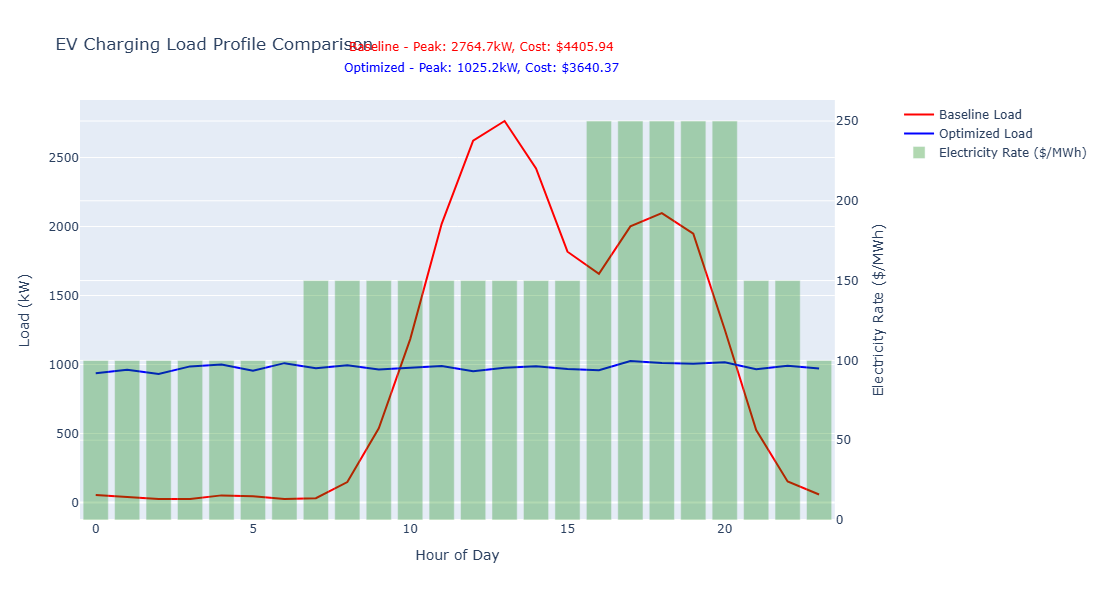

=== Performance Metrics Comparison ===
Peak Load Reduction: 2764.7kW → 1025.2kW (62.9%)
Cost Reduction: $4405.94 → $3640.37 (17.4%)
Load Factor Improvement: 0.354 → 0.956
Saved visualization to results.png


<Figure size 1600x1000 with 0 Axes>

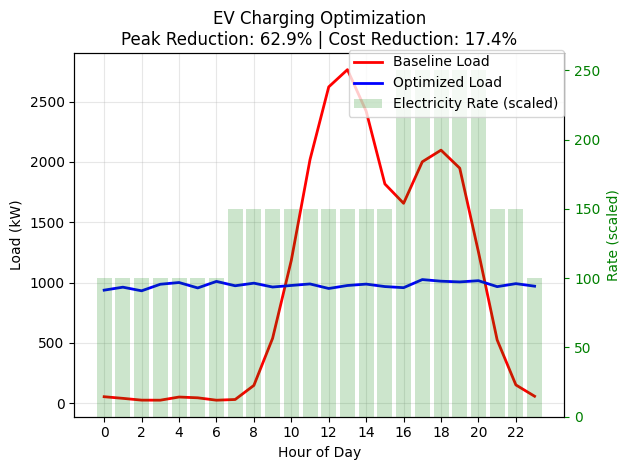

In [53]:
# Create and display visualizations
visualizer = ChargingVisualizer(
    charging_sessions=charging_sessions,
    optimized_schedule=optimized_schedule,
    optimized_load_profile=optimized_load_profile,
    time_of_use_rates=time_of_use_rates
)

print("Creating visualizations")
visualizer.plot_load_profiles()
visualizer.print_metrics_comparison()
visualizer.visualize_results()


## Additional Research Suggestions

If you have access to the full dataset, consider these additional analyses:

1. **User Behavior Analysis**:
   - Cluster users by charging patterns (time, duration, location)
   - Predict user charging demand based on historical patterns

2. **Station Utilization Analysis**:
   - Identify under/over utilized stations
   - Optimal station placement using spatial analysis

3. **Advanced ML Approaches**:
   - **Demand Forecasting**: LSTM networks for predicting charging demand
   - **Reinforcement Learning**: Dynamic pricing optimization
   - **Graph Neural Networks**: Model station networks and user flows

4. **Infrastructure Planning**:
   - Simulate different capacity expansion scenarios
   - Evaluate ROI for new station installations

### Recommended ML Stack:
- **Forecasting**: Prophet, PyCaret, or custom LSTMs
- **Clustering**: Scikit-learn (KMeans, DBSCAN) or PyCaret
- **Optimization**: OR-Tools, Pyomo, or reinforcement learning
- **Visualization**: Plotly Dash for interactive dashboards


In [58]:
class ChargingAnalytics:
    def __init__(self, charging_sessions):
        self.data = charging_sessions
    
    def create_user_behavior_dashboard(self):
        """Generate interactive user behavior plots."""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        
        # Plot 1: Charging by hour
        hourly = self.data.groupby('startTime')['sessionId'].count()
        hourly.plot(kind='bar', ax=ax1, color='skyblue')
        ax1.set_title('Charging Sessions by Start Hour')
        ax1.set_xlabel('Hour of Day')
        ax1.set_ylabel('Number of Sessions')
        
        # Plot 2: Energy demand by facility type
        facility_names = {1: 'Manufacturing', 2: 'Office', 3: 'R&D', 4: 'Other'}
        facility_data = self.data.replace({'facilityType': facility_names})\
                             .groupby('facilityType')['kwhTotal'].sum()
        facility_data.plot(kind='pie', ax=ax2, autopct='%1.1f%%')
        ax2.set_title('Energy Demand by Facility Type')
        ax2.set_ylabel('')
        
        plt.tight_layout()
        plt.savefig('user_behavior.png', dpi=300)
        return 

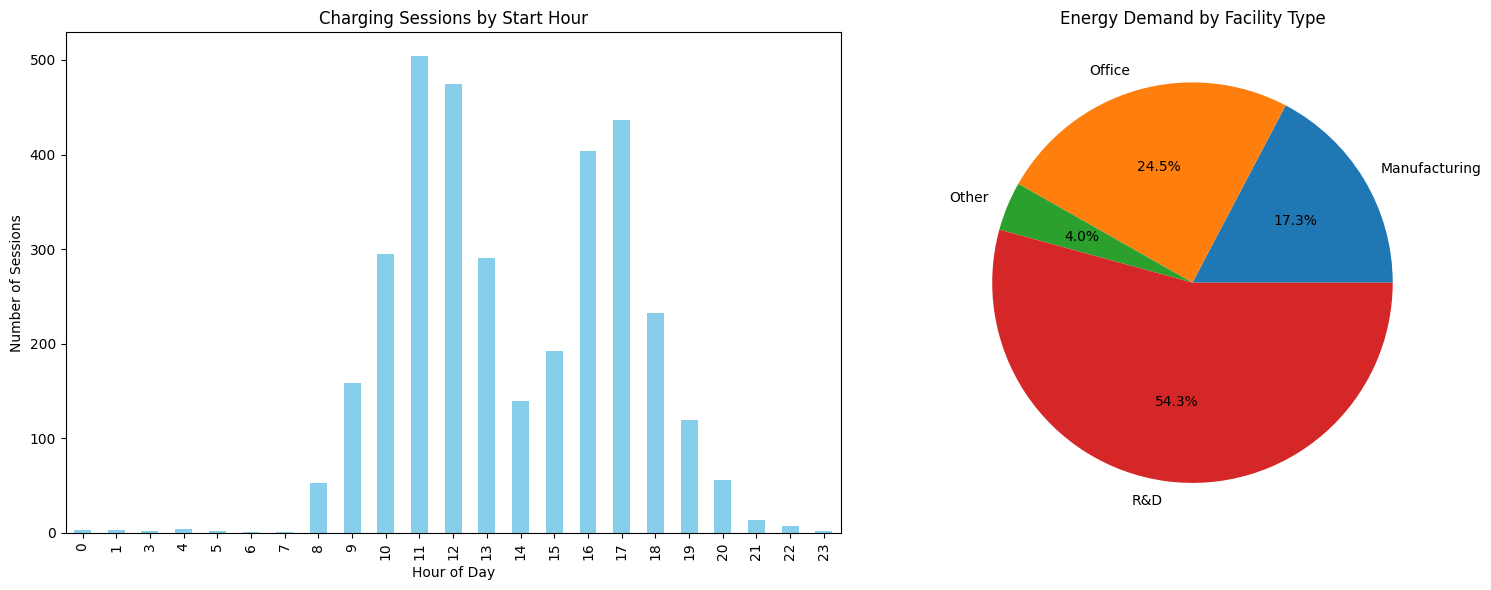

In [59]:
analytics = ChargingAnalytics(charging_sessions)
analytics.create_user_behavior_dashboard()